<a href="https://colab.research.google.com/github/fahadshakeel23/DataScience/blob/main/Historical_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [5]:
df = yf.download(['AAPL', 'MSFT', 'GOOGL'], start='2021-01-01', end='2023-01-01')

/tmp/ipython-input-1159043323.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(['AAPL', 'MSFT', 'GOOGL'], start='2021-01-01', end='2023-01-01')
[*********************100%***********************]  3 of 3 completed


In [6]:
df.head()

Price            Close                               High             \
Ticker            AAPL      GOOGL        MSFT        AAPL      GOOGL   
Date                                                                   
2021-01-04  126.096603  85.715324  209.273163  130.189064  87.520865   
2021-01-05  127.655602  86.406540  209.475067  128.366921  86.743215   
2021-01-06  123.358536  85.553932  204.043488  127.694603  86.601213   
2021-01-07  127.567924  88.109299  209.849945  128.259752  88.282103   
2021-01-08  128.668976  89.275764  211.128571  129.234127  89.351740   

Price                          Low                               Open  \
Ticker            MSFT        AAPL      GOOGL        MSFT        AAPL   
Date                                                                    
2021-01-04  214.377853  123.514452  84.772327  206.504511  130.101372   
2021-01-05  210.071105  125.141658  85.256968  207.360131  125.589887   
2021-01-06  208.119556  123.144167  84.224107  203.745476  124.449862   
2021-01-07  210.859350  124.586275  85.746589  205.447041  125.073473   
2021-01-08  212.051459  126.895568  87.457798  208.638714  129.039236   

Price                                 Volume                      
Ticker          GOOGL        MSFT       AAPL     GOOGL      MSFT  
Date                                                              
2021-01-04  87.397221  213.926024  143301900  37324000  37130100  
2021-01-05  85.663663  208.859813   97664900  20360000  23823000  
2021-01-06  84.430683  203.966579  155088000  46588000  35930700  
2021-01-07  85.746589  205.764269  109578200  41936000  27694500  
2021-01-08  88.249343  210.224913  105158200  35484000  22956200

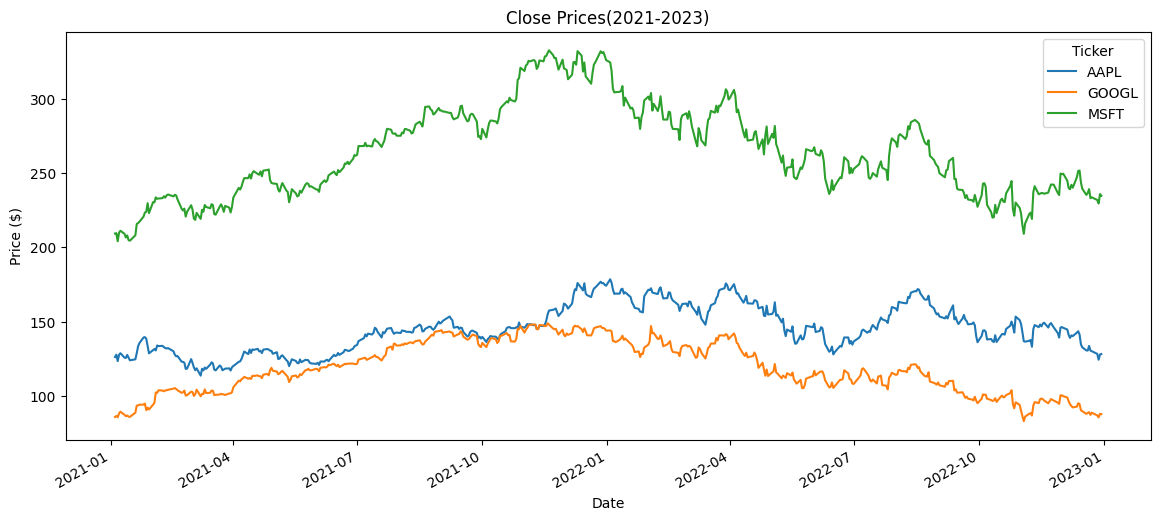

In [9]:
df['Close'].plot(figsize=(14,6))
plt.title("Close Prices(2021-2023)")
plt.ylabel("Price ($)")
plt.show()

In [10]:
returns = df['Close'].pct_change().dropna()
returns.head()

Ticker,AAPL,GOOGL,MSFT
Date,,,
2021-01-05,0.012364,0.008064,0.000965
2021-01-06,-0.033661,-0.009867,-0.025929
2021-01-07,0.034123,0.029868,0.028457
2021-01-08,0.008631,0.013239,0.006093
2021-01-11,-0.023249,-0.023106,-0.009699


In [11]:
for ticker in returns.columns:
    df['20MA_' + ticker] = df['Close'][ticker].rolling(window=20).mean()
    df['UpperBB_' + ticker] = df['20MA_' + ticker] + 2 * df['Close'][ticker].rolling(window=20).std()
    df['LowerBB_' + ticker] = df['20MA_' + ticker] - 2 * df['Close'][ticker].rolling(window=20).std()


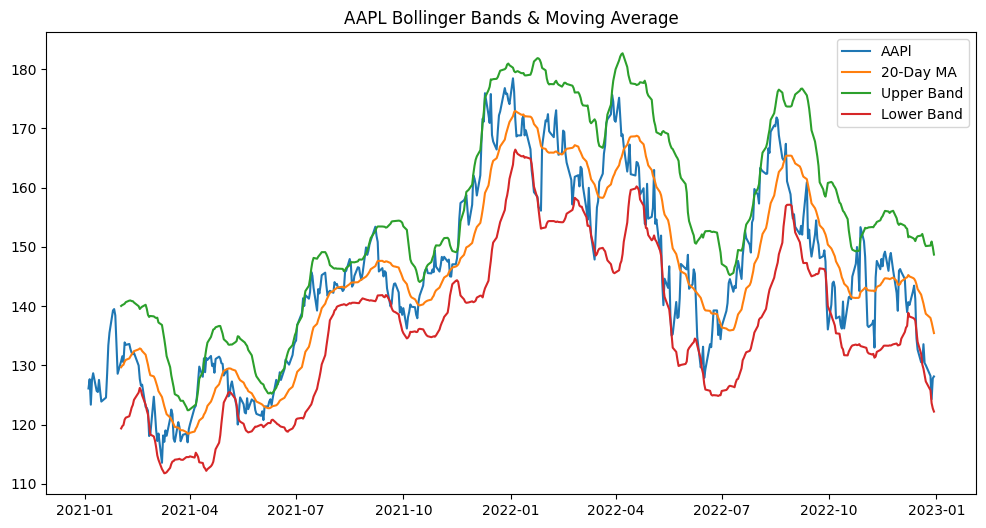

In [12]:
plt.figure(figsize=(12,6))
plt.plot(df['Close']['AAPL'], label='AAPl')
plt.plot(df['20MA_AAPL'], label='20-Day MA')
plt.plot(df['UpperBB_AAPL'], label='Upper Band')
plt.plot(df['LowerBB_AAPL'], label='Lower Band')
plt.legend()
plt.title('AAPL Bollinger Bands & Moving Average')
plt.show()

In [15]:
aapl_df = pd.DataFrame({
    'returns': returns['AAPL'],
    '20MA': df['20MA_AAPL'],
    'UpperBB': df['UpperBB_AAPL'],
    'LowerBB': df['LowerBB_AAPL']
}).dropna()

In [16]:
aapl_df['future_return'] = aapl_df['returns'].shift(-1)
model_df = aapl_df.dropna()

In [20]:
X = model_df[['returns', '20MA', 'UpperBB', 'LowerBB']]
y = model_df['future_return']

split= int(len(X)* 0.8)
X_train, X_test = X[:split], X[:split]
y_train, y_test = y[:split], y[:split]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Random Forest next-day AAPL return prediction RMSE:", mean_squared_error(y_test, y_pred))

Random Forest next-day AAPL return prediction RMSE: 5.33013213783152e-05


In [23]:
weights = np.array([1/3]*3)
port_returns = returns.mean(axis=1)
port_volatality = returns.std(axis=1)

risk_free_rate = 0.01
annualized_ret = port_returns.mean() * 252
annualized_vol =port_volatality.mean() *np.sqrt(252)
sharpe_ratio = (annualized_ret -risk_free_rate) / annualized_vol

print("Annualized Return:", annualized_ret)
print("Annualized Volatility:", annualized_vol)
print("Sharpe Ratio:", sharpe_ratio)

Annualized Return: 0.07285282304291259
Annualized Volatility: 0.11518357059123481
Sharpe Ratio: 0.5456752444840041


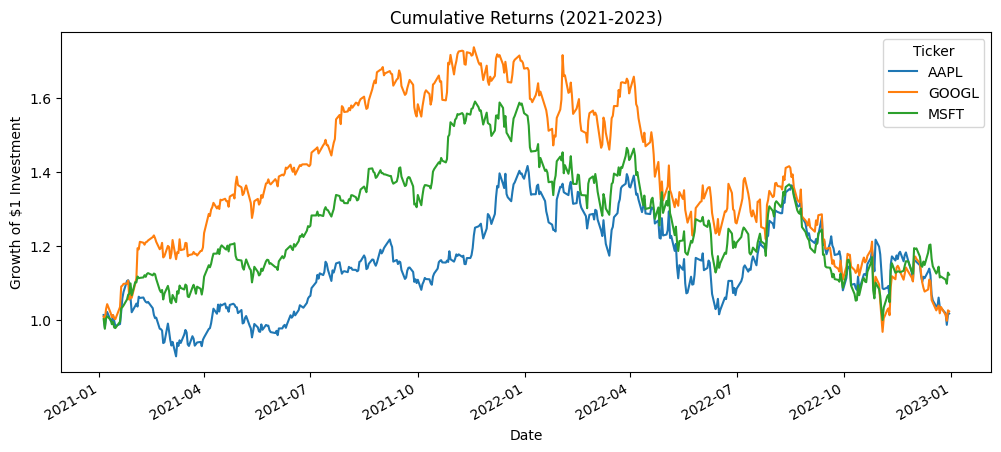

        Total Return (%)  Volatility (%)
Ticker                                  
AAPL              -24.69           35.63
GOOGL             -43.04           38.58
MSFT              -27.56           35.25


In [24]:
# Plot cumulative returns
cumulative_returns = (1 + returns).cumprod()
cumulative_returns.plot(figsize=(12,5))
plt.title("Cumulative Returns (2021-2023)")
plt.ylabel("Growth of $1 Investment")
plt.show()

# Summary table of last one-year performance
summary = pd.DataFrame({
    'Total Return (%)': (returns.tail(252).sum() * 100).round(2),
    'Volatility (%)': (returns.tail(252).std() * np.sqrt(252) * 100).round(2)
})
print(summary)
